In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from matplotlib import pyplot as plt
import seaborn as sns
# magic incantation to help matplotlib work with our jupyter notebook
%matplotlib inline 

#### Цель работы: 
Пользуясь открытыми данными об экспрессии генов в разных клетках, кластеризовать клетки и проверить, какая биологическая разница между кластерами 

Используются открытые данные о дифференциальной экспрессии генов в мозге мышей https://tabula-muris.ds.czbiohub.org/

In [202]:
scaledcounts = pd.read_csv("C:/Users/57662/Downloads/brain_counts.csv")

In [2]:
scaledcounts = pd.read_csv("/home/rita/Downloads/brain_counts.csv")

In [203]:
scaledcounts.head()

,Unnamed: 0,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
0,A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
1,A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,...,0,0,0,0,0,195,0,0,113,0
3,A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,...,0,0,0,0,125,0,1,0,0,0
4,A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


Для определения числа кластеров воспользуемся elbow методом: Обучаем модели кластеризации k средних для разного количества кластеров и строим зависимость суммы квадратов расстояний от каждого элемента кластера до соответствующего центроида от количества кластеров и находим точку изгиба графика, при этом колонку с кодовым именем нужно убрать - она не задает координату вектора.

In [ ]:
K=range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(scaledcounts.drop(['Unnamed: 0'], axis=1))
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [ ]:
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
mycenters

<AxesSubplot:xlabel='Clusters', ylabel='WSS'>

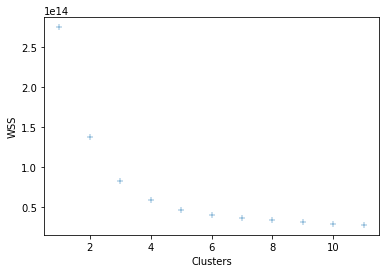

In [6]:
sns.scatterplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")

Четкого угла на гравфике не видно, но для начала можно взять n_clusters = 7. Посмотрим еще, не покажет ли нам локального максимума метод силуэтов

In [51]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

for n_clusters in range(3,10):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(scaledcounts.drop(['Unnamed: 0'], axis=1))
    centers = clusterer.cluster_centers_

    score = silhouette_score(scaledcounts.drop(['Unnamed: 0'], axis=1), preds)
    silhouette_scores.append(score)

In [53]:
Clusters_score = pd.DataFrame({'Clusters' : range(3,10), 'silhouette_scores' : silhouette_scores})
Clusters_score

,Clusters,silhouette_scores
0,3,0.700723
1,4,0.578845
2,5,0.504330
3,6,0.437675
4,7,0.379674
5,8,0.368683
6,9,0.361607


<AxesSubplot:xlabel='Clusters', ylabel='silhouette_scores'>

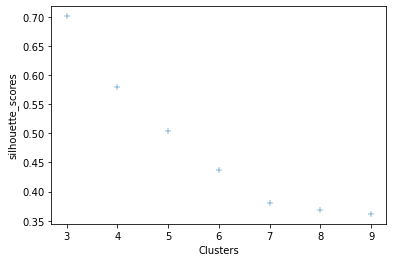

In [54]:
sns.scatterplot(x = 'Clusters', y = 'silhouette_scores', data = Clusters_score, marker="+")

Никакого четкого максимума, остановимся на 7ми кластерах. Попробуем визуализовать результать с помощью метода понижения размерности (Principal Component Analysis):

In [ ]:
pca = PCA(n_components = 2)
pca.fit(scaledcounts.drop(['Unnamed: 0'], axis=1))
x_pca = pca.transform(scaledcounts.drop(['Unnamed: 0'], axis=1))


Сразу вместе с тем, как рисовать PCA, проведем k-means кластеризацию и визуализируем ее результаты на проекции на 2D

In [ ]:
km = KMeans(n_clusters = 7)
y_predict = km.fit_predict(scaledcounts.drop(['Unnamed: 0'], axis=1))
scaledcounts['cluster'] = y_predict

Добавляем столбец номеров кластеров к столбцам PC1 и PC2:

In [9]:
import numpy as np
np.insert(x_pca,2,y_predict,axis=1)

array([[-1.77407919e+05, -1.26224805e+04,  0.00000000e+00],
       [-1.57844598e+05, -1.87540143e+04,  0.00000000e+00],
       [ 1.60008048e+04,  8.16227401e+04,  4.00000000e+00],
       ...,
       [-1.73973674e+05, -1.33934616e+04,  0.00000000e+00],
       [-3.79441358e+04,  1.48549154e+04,  4.00000000e+00],
       [-1.78065952e+05, -1.30685856e+04,  0.00000000e+00]])

Преобразуем в более удобный дата фрейм:

In [10]:
df = pd.DataFrame(np.insert(x_pca,2,y_predict,axis=1)).rename(columns={2:'cluster'})
df

,0,1,cluster
0,-177407.918590,-12622.480524,0.0
1,-157844.597528,-18754.014284,0.0
2,16000.804822,81622.740098,4.0
3,-131256.837643,-18220.629936,0.0
4,-71464.649824,-25776.032993,4.0
...,...,...,...
3396,-93902.057099,-21945.110509,0.0
3397,-119573.873556,-6535.428476,0.0
3398,-173973.674045,-13393.461569,0.0
3399,-37944.135805,14854.915438,4.0


Рисуем раскрашенные точки

<Figure size 576x648 with 0 Axes>

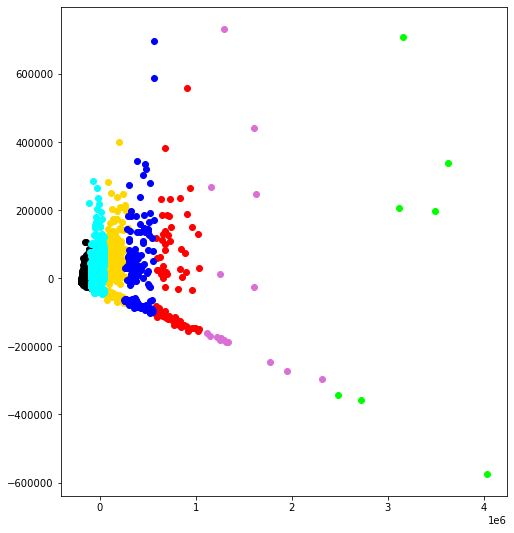

In [11]:
plt.figure(figsize=(8,9))
colors = ['black','red', 'gold', 'lime', 'cyan', 'orchid', 'b']

plt.figure(figsize=(8,9))
for i in range(7):
    sub_df = df.loc[df['cluster'] == i]
    plt.scatter(sub_df[0],sub_df[1], c = colors[i])

Видно разделение точек по кластерам, разброс голубых и красных точек может быть побочным эффектом понижения размерности данных.

Так просто с PCA у нас ничего хорошего не получается, а значит надо обратиться к разным способам пре-обработки данных в биоинформатике. Обычно удаляются гены, в которых слишком мало прочтений, чтобы нести какую-либо биологическую значимость. Например, гены, отвечающие за сокращение мышц, нам в анализе экспрессии клеток мозга не очень нужны, поэтому, чтобы уменьшить размерность данных, их удаляют

In [6]:
scaledcounts = scaledcounts.set_index("Unnamed: 0")
scaledcounts.index.names = [None]
count_matrix = scaledcounts.iloc[:, :23433]

Потребуем чтобы для каждого гена у хотя бы 100 (из 3401) клеточных линий у нас было не 0 прочтений 

In [7]:
count_matrix = count_matrix.T[(count_matrix.T > 0).sum(axis=1) >= 100].T

In [8]:
count_matrix.shape

(3401, 12729)

In [9]:
scaledcounts.shape

(3401, 23433)

Таким простым фильтром мы отбросили почти половину генов, которые не могли нам показать статистически значимую разницу между клетками, так как экспрессировались в малом их проценте

Для того, чтобы высокоэкспрессируемые гены вносили сравнимый с низкоэкспрессируемыми вклад в PCA, можно подавить их большую абсолютную вариацию логарифмическим преобразованием

In [11]:
import numpy as np
cmtrx = np.log2(count_matrix + 1)

Добавление единицы под логарифм здесь позволяет получать тот же самый 0 из нулевых прочтений

In [12]:
cmtrx

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zw10,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
A1.B003290.3_38_F.1.1,6.977280,4.087463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.169925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.781360
A1.B003728.3_56_F.1.1,0.000000,0.000000,0.000000,0.000000,8.344296,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1.MAA000560.3_10_M.1.1,8.447083,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,8.308339,0.000000,0.000000,...,0.000000,8.060696,0.000000,0.000000,0.000000,0.000000,0.000000,7.614710,0.000000,6.832890
A1.MAA000564.3_10_M.1.1,5.392317,5.209453,0.000000,0.000000,4.643856,0.000000,3.906891,0.000000,0.000000,2.000000,...,1.584963,0.000000,0.000000,0.000000,0.000000,0.000000,6.977280,0.000000,1.000000,0.000000
A1.MAA000923.3_9_M.1.1,5.754888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.357552,0.000000,0.000000,0.000000,0.000000
A1.MAA000930.3_8_M.1.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.199672,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
A1.MAA000932.3_11_M.1.1,0.000000,1.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1.MAA000940.3_8_M.1.1,4.087463,0.000000,0.000000,1.584963,1.000000,0.000000,3.169925,4.807355,0.000000,1.584963,...,0.000000,6.807355,0.000000,0.000000,2.807355,2.000000,0.000000,0.000000,0.000000,3.807355
A1.MAA001854.3_38_F.1.1,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1.MAA001894.3_39_F.1.1,5.087463,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.584963,0.000000,4.807355


Теперь сравним, какой вид PCA у нас получится

[0.11650739 0.06425546]


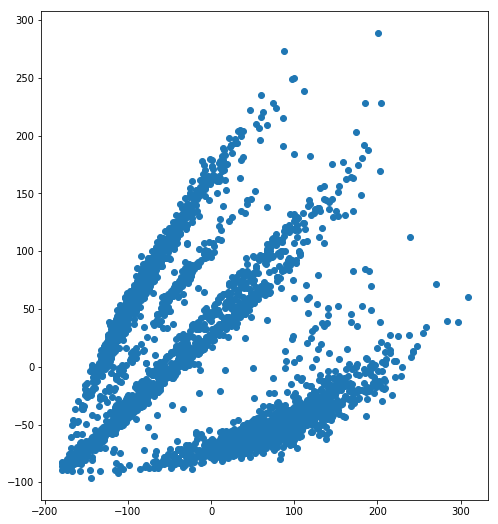

In [13]:
pca = PCA(n_components = 2)
pca.fit(cmtrx)

print(pca.explained_variance_ratio_)

y_pca = pca.transform(cmtrx)
plt.figure(figsize=(8,9))
plt.scatter(y_pca[:,0],y_pca[:,1])

Уже намного легче различимы кластеры, однако, например k-means будет сложно их различать, поскольку они не сферические. Для сравнения с PCA (линейным преобразованием) построим t-SNE (нелинейная проекция на 2D)

In [14]:
from sklearn.manifold import TSNE

In [15]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(cmtrx) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3401 samples in 2.928s...
[t-SNE] Computed neighbors for 3401 samples in 195.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3401
[t-SNE] Computed conditional probabilities for sample 2000 / 3401
[t-SNE] Computed conditional probabilities for sample 3000 / 3401
[t-SNE] Computed conditional probabilities for sample 3401 / 3401
[t-SNE] Mean sigma: 46.524061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.956154
[t-SNE] KL divergence after 1000 iterations: 2.287005


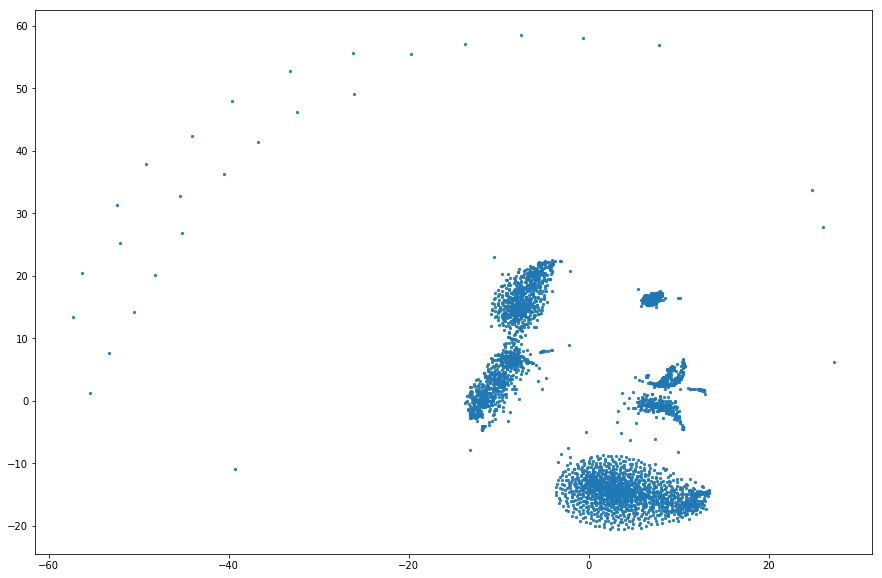

In [16]:
plt.figure(figsize = (15, 10))
plt.scatter(z[:,0], z[:,1], alpha = 0.9, s = 5)

Явно есть выбросы, которые для k-means мы выкинем

In [17]:
cmtrx
cmtrx['tsne_coord1'], cmtrx['tsne_coord2'] = z[:, 0], z[:, 1]
cmtrx.head()

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6,tsne_coord1,tsne_coord2
A1.B003290.3_38_F.1.1,6.977280,4.087463,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,3.169925,...,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,5.78136,6.517261,3.785241
A1.B003728.3_56_F.1.1,0.000000,0.000000,0.0,0.0,8.344296,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.00000,-9.381578,2.109472
A1.MAA000560.3_10_M.1.1,8.447083,0.000000,0.0,0.0,2.584963,0.0,0.000000,8.308339,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.00000,7.61471,0.0,6.83289,5.712108,-15.768988
A1.MAA000564.3_10_M.1.1,5.392317,5.209453,0.0,0.0,4.643856,0.0,3.906891,0.000000,0.0,2.000000,...,0.0,0.0,0.0,0.000000,6.97728,0.00000,1.0,0.00000,-5.422341,20.570127
A1.MAA000923.3_9_M.1.1,5.754888,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.000000,...,0.0,0.0,0.0,6.357552,0.00000,0.00000,0.0,0.00000,-10.914634,3.110567


In [18]:
outliers = cmtrx[(cmtrx["tsne_coord1"]<-20) | (cmtrx["tsne_coord2"]>25)]
tsne_main = cmtrx[(cmtrx["tsne_coord1"]>-20) & (cmtrx["tsne_coord2"]<25)]


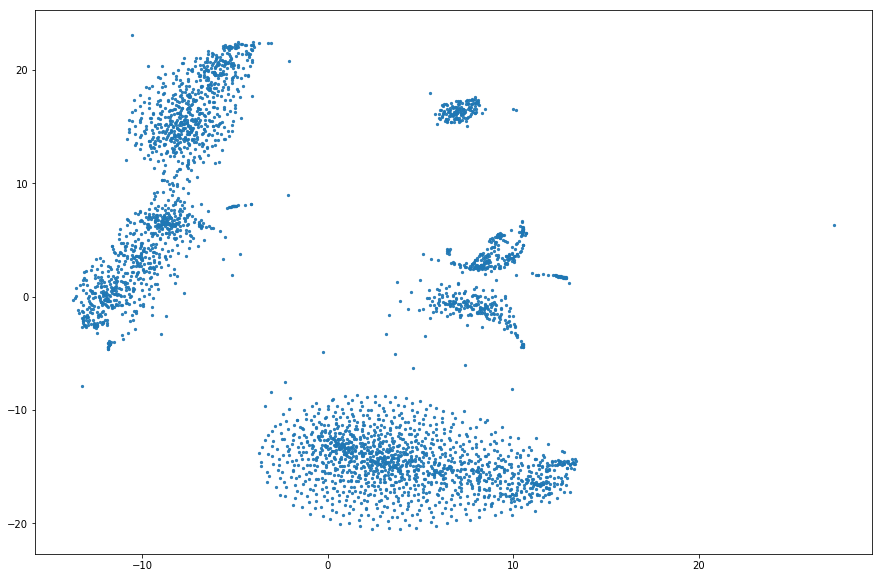

In [19]:
plt.figure(figsize = (15, 10))
plt.scatter(tsne_main["tsne_coord1"], tsne_main["tsne_coord2"], alpha = 0.9, s = 5)

Теперь сделаем k-means чтобы выделить кластеры, определяя количество кластеров методом силуэтов

In [122]:
from sklearn.metrics import silhouette_score
silhouette_scores2 = []

for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(tsne_main.drop(['tsne_coord1','tsne_coord2'], axis=1))
    centers = clusterer.cluster_centers_

    score = silhouette_score(tsne_main.drop(['tsne_coord1','tsne_coord2'], axis=1), preds)
    silhouette_scores2.append(score)

<AxesSubplot:xlabel='Clusters', ylabel='silhouette_scores'>

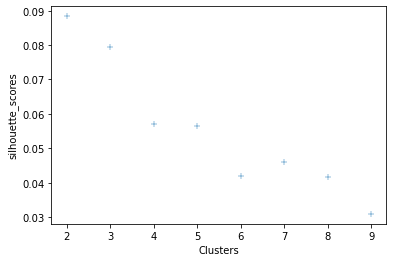

In [123]:
Clusters_score = pd.DataFrame({'Clusters' : range(2,10), 'silhouette_scores' : silhouette_scores2})
sns.scatterplot(x = 'Clusters', y = 'silhouette_scores', data = Clusters_score, marker="+")

In [125]:
tsne_main

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6,tsne_coord1,tsne_coord2
A1.B003290.3_38_F.1.1,6.977280,4.087463,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.169925,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.781360,5.711510,5.387627
A1.B003728.3_56_F.1.1,0.000000,0.000000,0.0,0.000000,8.344296,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.799181,2.054926
A1.MAA000560.3_10_M.1.1,8.447083,0.000000,0.0,0.000000,2.584963,0.0,0.000000,8.308339,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,7.614710,0.000000,6.832890,6.920167,-13.986818
A1.MAA000564.3_10_M.1.1,5.392317,5.209453,0.0,0.000000,4.643856,0.0,3.906891,0.000000,0.0,2.000000,...,0.0,0.0,0.000000,0.000000,6.977280,0.000000,1.000000,0.000000,-6.908506,20.587294
A1.MAA000923.3_9_M.1.1,5.754888,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.000000,...,0.0,0.0,0.000000,6.357552,0.000000,0.000000,0.000000,0.000000,-12.339684,3.043000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA000926.3_9_M.1.1,6.807355,0.000000,0.0,5.044394,5.807355,6.0,0.000000,3.700440,0.0,5.321928,...,0.0,0.0,0.000000,0.000000,2.321928,3.700440,6.022368,2.000000,6.312922,0.252924
P9.MAA000930.3_8_M.1.1,7.807355,1.584963,0.0,0.000000,5.643856,0.0,0.000000,4.584963,0.0,0.000000,...,0.0,0.0,0.000000,3.459432,1.000000,5.672425,1.584963,0.000000,8.635746,-9.432851
P9.MAA000932.3_11_M.1.1,7.087463,5.392317,0.0,0.000000,0.000000,0.0,0.000000,4.807355,0.0,3.169925,...,0.0,0.0,4.321928,0.000000,4.247928,0.000000,0.000000,5.523562,-6.563676,17.682610
P9.MAA000935.3_8_M.1.1,7.022368,5.781360,0.0,0.000000,7.714246,0.0,0.000000,5.906891,0.0,6.066089,...,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,5.857981,2.507166,-14.465229


In [23]:
km = KMeans(n_clusters = 7)
y_predict2 = km.fit_predict(tsne_main.drop(['tsne_coord1','tsne_coord2'],axis=1))
tsne_main['cluster'] = y_predict2

tsne_main.head()

/home/bobik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6,tsne_coord1,tsne_coord2,cluster
A1.B003290.3_38_F.1.1,6.977280,4.087463,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,3.169925,...,0.0,0.0,0.000000,0.00000,0.00000,0.0,5.78136,6.517261,3.785241,0
A1.B003728.3_56_F.1.1,0.000000,0.000000,0.0,0.0,8.344296,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.00000,-9.381578,2.109472,4
A1.MAA000560.3_10_M.1.1,8.447083,0.000000,0.0,0.0,2.584963,0.0,0.000000,8.308339,0.0,0.000000,...,0.0,0.0,0.000000,0.00000,7.61471,0.0,6.83289,5.712108,-15.768988,2
A1.MAA000564.3_10_M.1.1,5.392317,5.209453,0.0,0.0,4.643856,0.0,3.906891,0.000000,0.0,2.000000,...,0.0,0.0,0.000000,6.97728,0.00000,1.0,0.00000,-5.422341,20.570127,5
A1.MAA000923.3_9_M.1.1,5.754888,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.000000,...,0.0,0.0,6.357552,0.00000,0.00000,0.0,0.00000,-10.914634,3.110567,4


In [26]:
raw_expressions_filtred = scaledcounts.loc[scaledcounts.index.isin(tsne_main.index),scaledcounts.columns.isin(count_matrix.columns)]
raw_expressions_filtred['cluster'] = y_predict2
raw_expressions_filtred.head()

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6,cluster
A1.B003290.3_38_F.1.1,125,16,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,324,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
A1.MAA000560.3_10_M.1.1,348,0,0,0,5,0,0,316,0,0,...,266,0,0,0,0,0,195,0,113,2
A1.MAA000564.3_10_M.1.1,41,36,0,0,24,0,14,0,0,3,...,0,0,0,0,0,125,0,1,0,5
A1.MAA000923.3_9_M.1.1,53,0,0,0,0,0,0,0,0,3,...,0,0,0,0,81,0,0,0,0,4


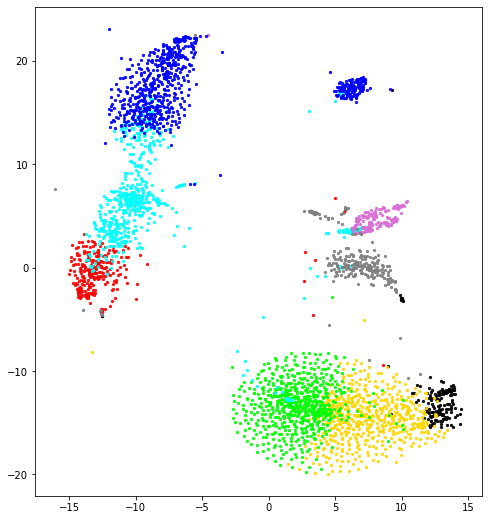

In [64]:
colors = ['black','red', 'gold', 'lime', 'cyan', 'orchid', 'b', 'grey']

plt.figure(figsize=(8,9))
for i in range(8):
    sub_tsne = tsne_main.loc[tsne_main['cluster'] == i]
    plt.scatter(sub_tsne['tsne_coord1'],sub_tsne['tsne_coord2'], c = colors[i], alpha = 0.9, s = 5)

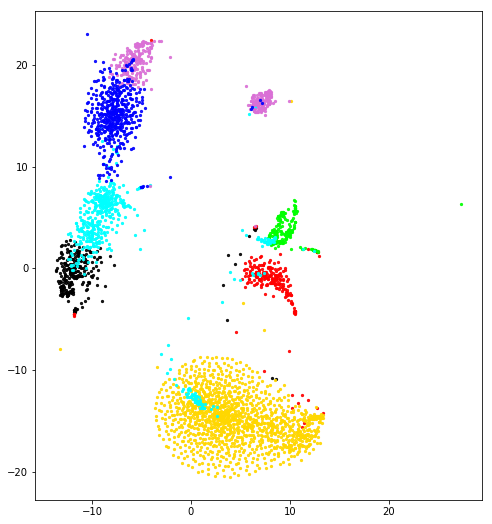

In [24]:
colors = ['black','red', 'gold', 'lime', 'cyan', 'orchid', 'b']

plt.figure(figsize=(8,9))
for i in range(7):
    sub_tsne = tsne_main.loc[tsne_main['cluster'] == i]
    plt.scatter(sub_tsne['tsne_coord1'],sub_tsne['tsne_coord2'], c = colors[i], alpha = 0.9, s = 5)

<Figure size 576x648 with 0 Axes>

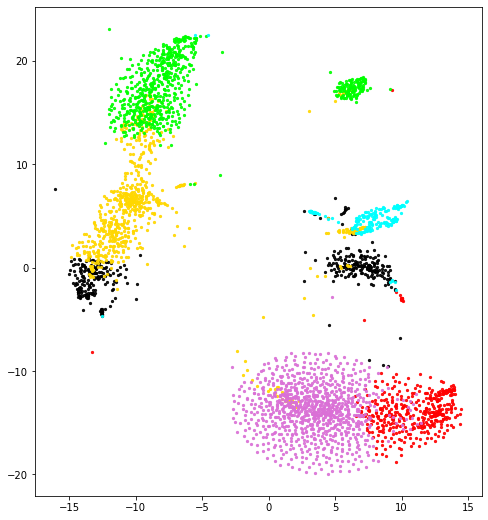

In [45]:

colors = ['black','red', 'gold', 'lime', 'cyan', 'orchid']

plt.figure(figsize=(8,9))
for i in range(6):
    sub_tsne = tsne_main.loc[tsne_main['cluster'] == i]
    plt.scatter(sub_tsne['tsne_coord1'],sub_tsne['tsne_coord2'], c = colors[i], alpha = 0.9, s = 5)

Лучше всего получается картина при 7 кластерах, поэтому дальше исследуем именно их


Поскольку известно, что данные их мозга мышей, посмотрим на наборы маркеров некоторых типов клеток мозга, и сравним их экспрессию в разных кластерах. Поскольку мы берем только по паре-тройке известных маркеров, это не будет точным анализом соответствия кластеров типам клеток, но мы сможем предположить тип клеток в кластере

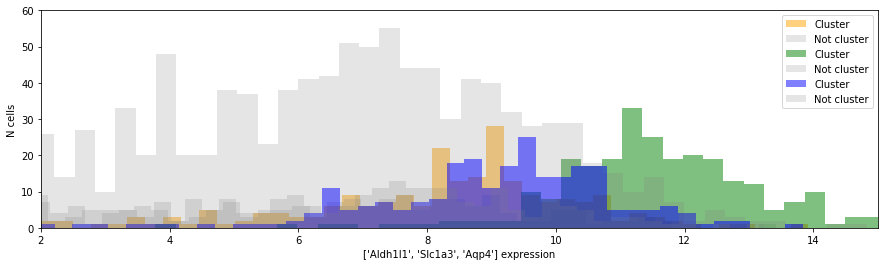

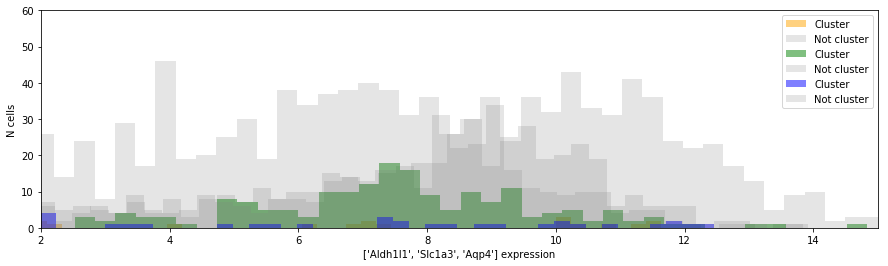

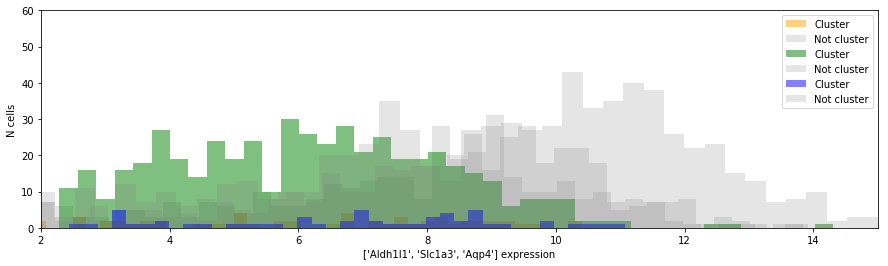

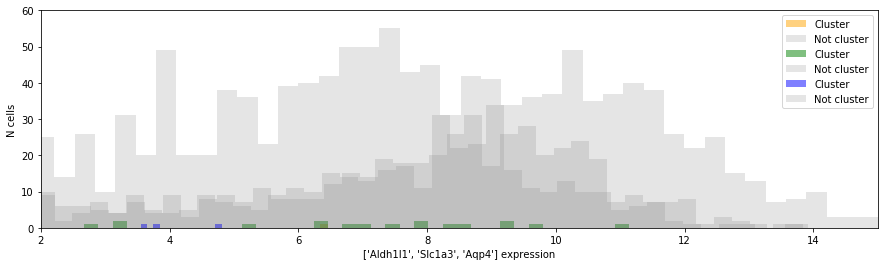

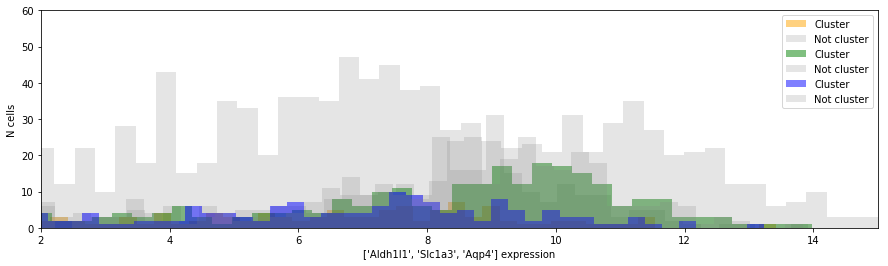

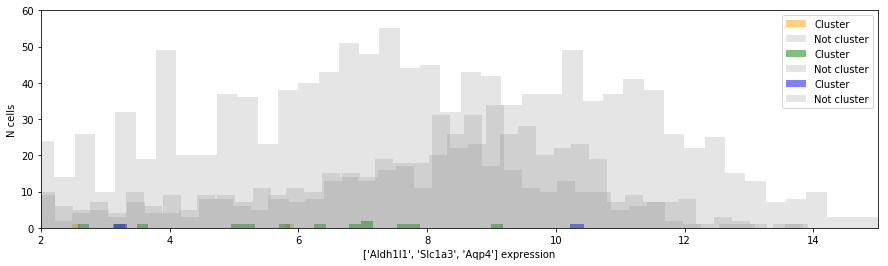

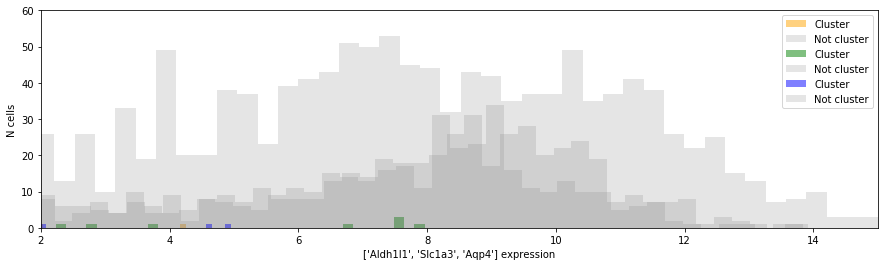

In [41]:
astrocyte_markers = ['Aldh1l1', 'Slc1a3', 'Aqp4']
colors = ['orange', 'green', 'blue']
from scipy.stats import ttest_ind

for i in range(7):
    cluster_i = tsne_main[tsne_main['cluster'] == i]
    all_other_cells = tsne_main[tsne_main['cluster'] != i]
    
    plt.figure(figsize=(15,4))
    
    for number in range(3):
        cluster_i_marker = cluster_i[astrocyte_markers[number]] 
        plt.hist(cluster_i_marker, bins=50, color=colors[number], alpha=0.5, label='Cluster') # Plot distribution

        all_other_cells_marker = all_other_cells[astrocyte_markers[number]]
        plt.hist(all_other_cells_marker, bins=50, color='grey', alpha=0.2, label='Not cluster')

        plt.ylim(0,60)
        plt.xlim(2,15)
        plt.xlabel('%s expression'%astrocyte_marker) # label our axes
        plt.ylabel('N cells')
        plt.legend()
    
    #ttest = ttest_ind(cluster_i_marker, 
    #      all_other_cells_marker, 
    #      equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
    #      nan_policy='omit') # omit NaN values
    #print(ttest)

Скорее всего большинство астроцитов оказались в первом кластере. Стоит заметить, что если бы мы рассматривали гены-маркеры без гена Aldh1l1, результат бы кардинально отличался

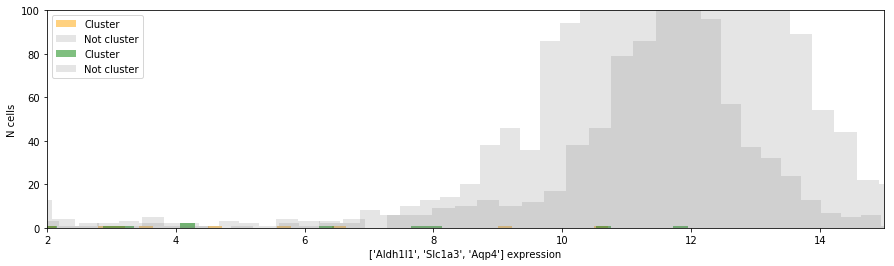

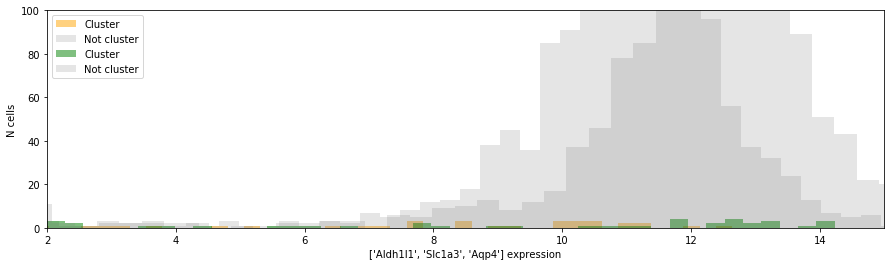

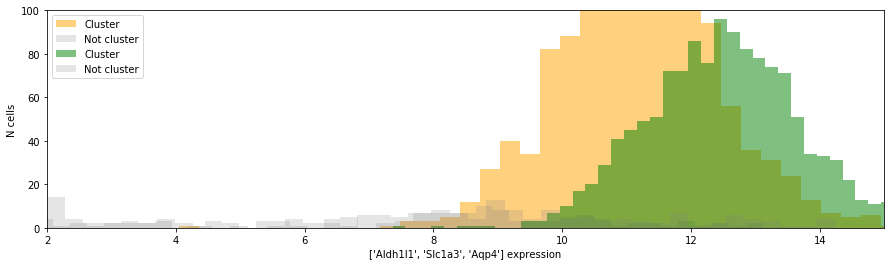

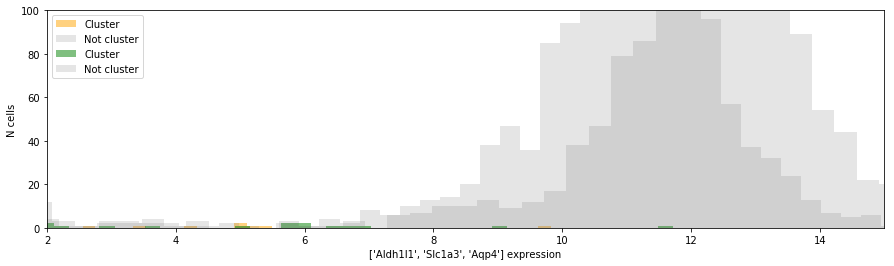

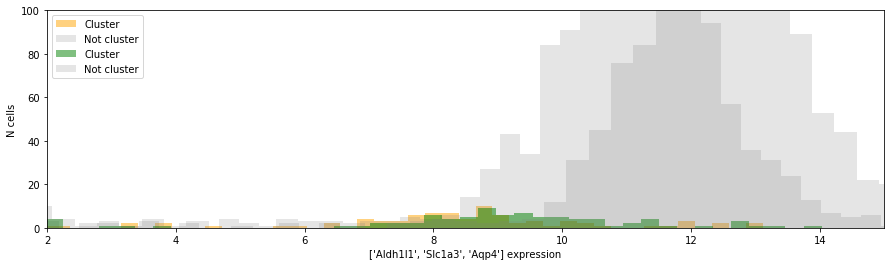

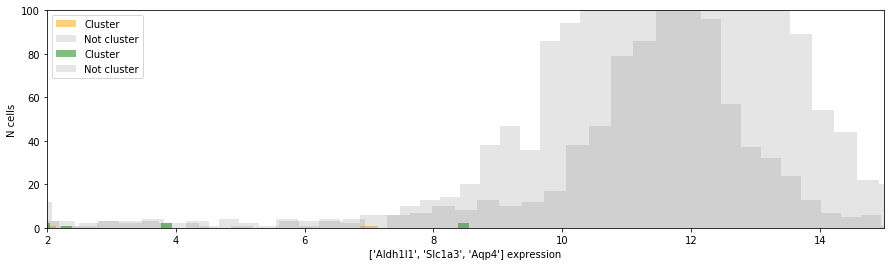

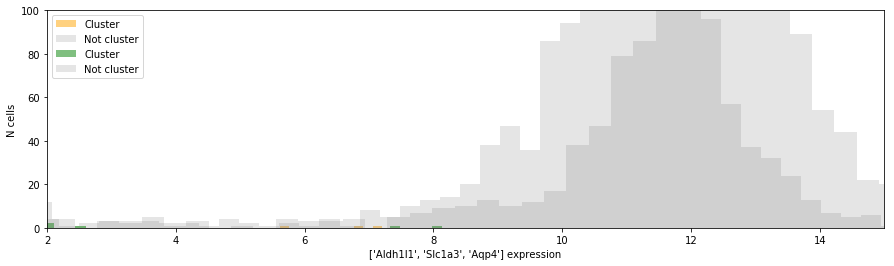

In [44]:
oligodendrocyte_markers = ['Mog','Mag']
colors = ['orange', 'green']
from scipy.stats import ttest_ind

for i in range(7):
    cluster_i = tsne_main[tsne_main['cluster'] == i]
    all_other_cells = tsne_main[tsne_main['cluster'] != i]
    
    plt.figure(figsize=(15,4))
    
    for number in range(2):
        cluster_i_marker = cluster_i[oligodendrocyte_markers[number]] 
        plt.hist(cluster_i_marker, bins=50, color=colors[number], alpha=0.5, label='Cluster') # Plot distribution

        all_other_cells_marker = all_other_cells[oligodendrocyte_markers[number]]
        plt.hist(all_other_cells_marker, bins=50, color='grey', alpha=0.2, label='Not cluster')

        plt.ylim(0,100)
        plt.xlim(2,15)
        plt.xlabel('%s expression'%astrocyte_marker) # label our axes
        plt.ylabel('N cells')
        plt.legend()

Большинство олигодендроцитов попали в третий кластер, хотя какая-то их часть могла оказаться и в пятом кластере

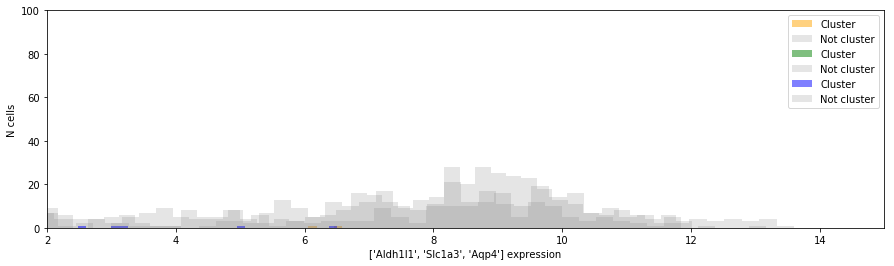

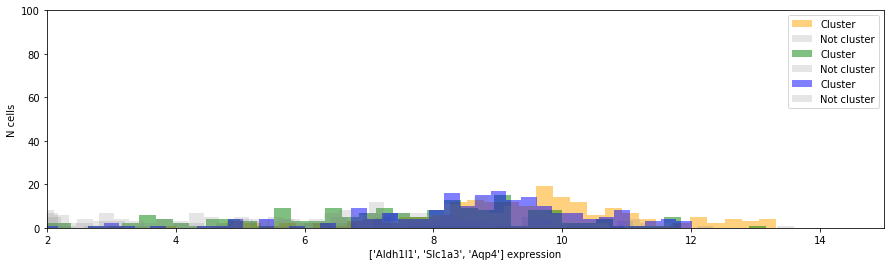

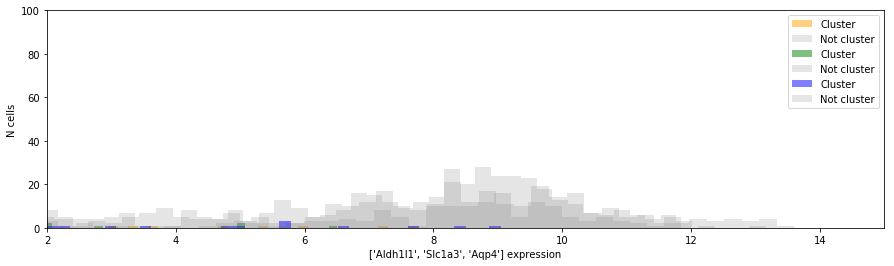

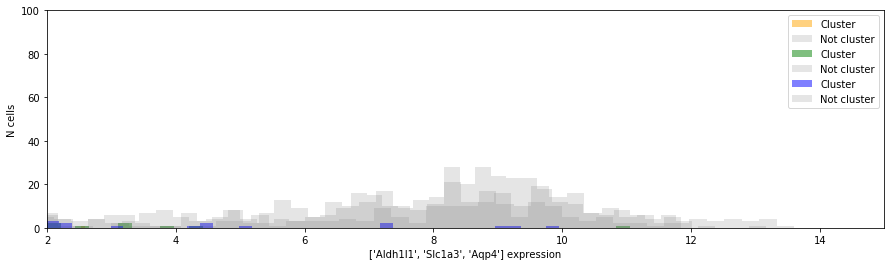

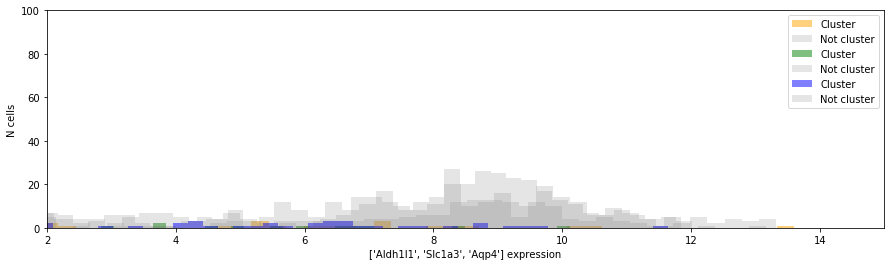

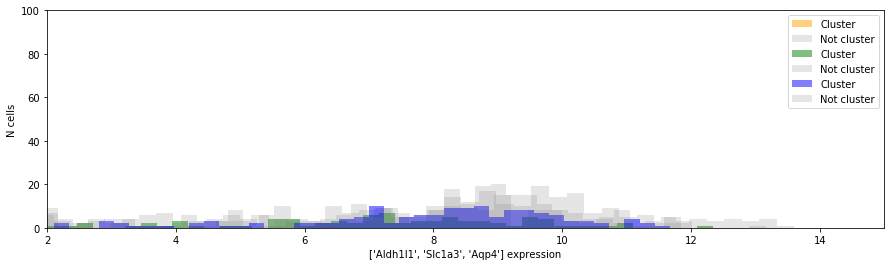

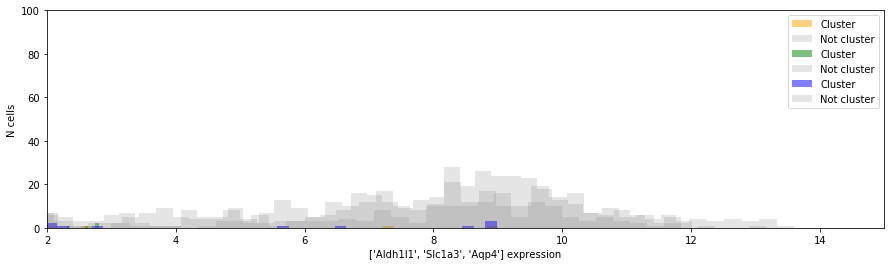

In [45]:
oligodendrocyte_precursor_markers = ['Pdgfra','Susd5','Cspg4']
colors = ['orange', 'green','blue']
from scipy.stats import ttest_ind

for i in range(7):
    cluster_i = tsne_main[tsne_main['cluster'] == i]
    all_other_cells = tsne_main[tsne_main['cluster'] != i]
    
    plt.figure(figsize=(15,4))
    
    for number in range(3):
        cluster_i_marker = cluster_i[oligodendrocyte_precursor_markers[number]] 
        plt.hist(cluster_i_marker, bins=50, color=colors[number], alpha=0.5, label='Cluster') # Plot distribution

        all_other_cells_marker = all_other_cells[oligodendrocyte_precursor_markers[number]]
        plt.hist(all_other_cells_marker, bins=50, color='grey', alpha=0.2, label='Not cluster')

        plt.ylim(0,100)
        plt.xlim(2,15)
        plt.xlabel('%s expression'%astrocyte_marker) # label our axes
        plt.ylabel('N cells')
        plt.legend()

Судя по этим маркерным генам, нам удалось достаточно четко отделить клетки прекурсоры олигодендроцитов от самих олигодендроцитов

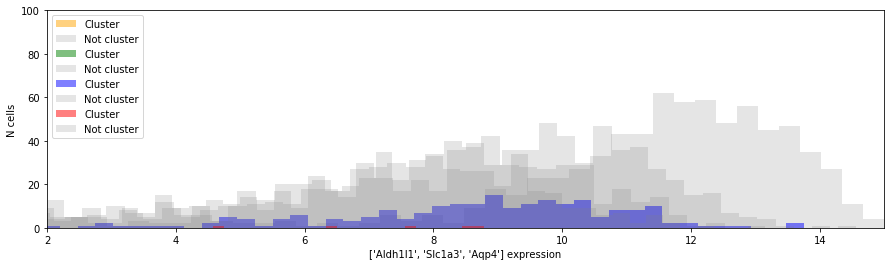

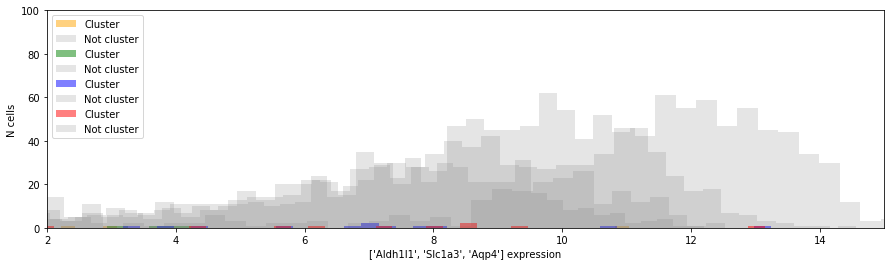

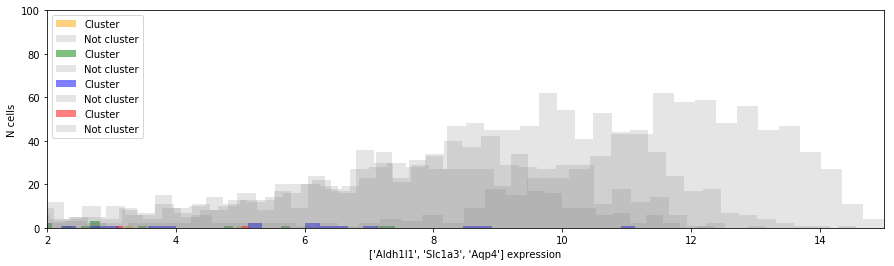

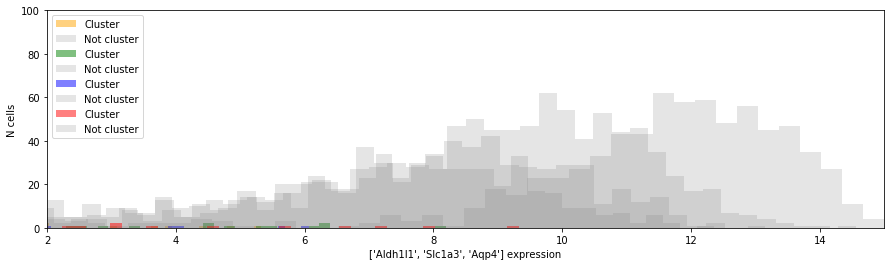

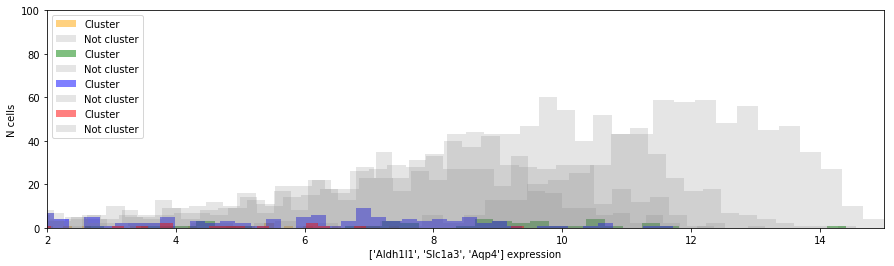

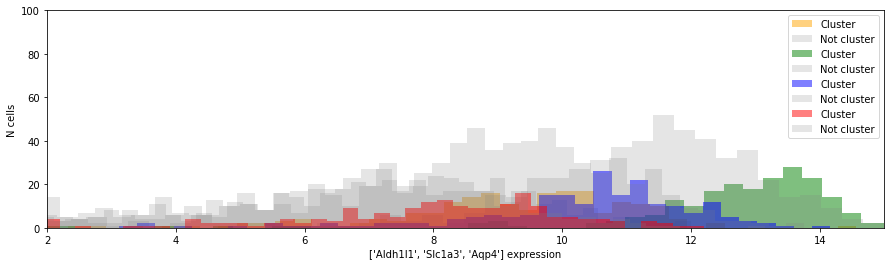

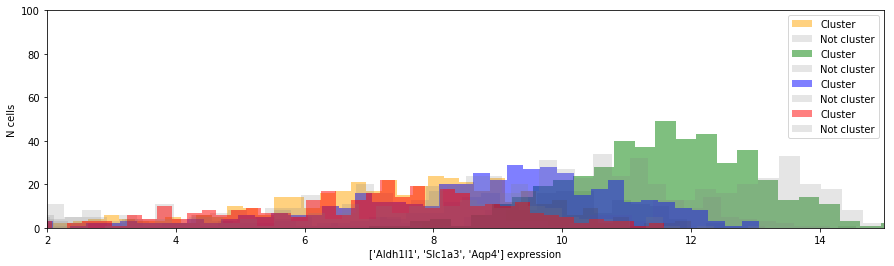

In [46]:
endothelial_markers = ['Pecam1','Cldn5','Slco1c1','Ocln']
colors = ['orange', 'green','blue','r']
from scipy.stats import ttest_ind

for i in range(7):
    cluster_i = tsne_main[tsne_main['cluster'] == i]
    all_other_cells = tsne_main[tsne_main['cluster'] != i]
    
    plt.figure(figsize=(15,4))
    
    for number in range(4):
        cluster_i_marker = cluster_i[endothelial_markers[number]] 
        plt.hist(cluster_i_marker, bins=50, color=colors[number], alpha=0.5, label='Cluster') # Plot distribution

        all_other_cells_marker = all_other_cells[endothelial_markers[number]]
        plt.hist(all_other_cells_marker, bins=50, color='grey', alpha=0.2, label='Not cluster')

        plt.ylim(0,100)
        plt.xlim(2,15)
        plt.xlabel('%s expression'%astrocyte_marker) # label our axes
        plt.ylabel('N cells')
        plt.legend()

Клетки эндотелия попали в несколько кластеров, но в большинстве своем заметны в в последних двух кластерах

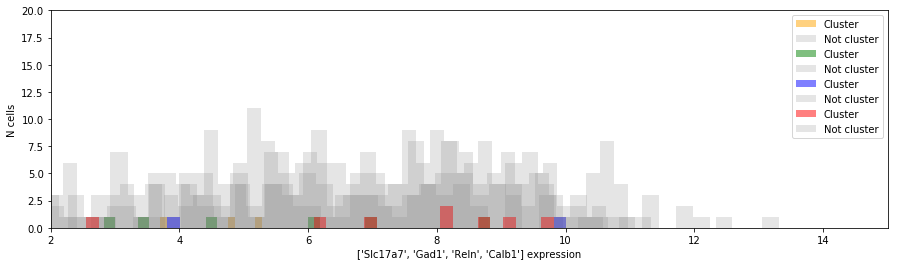

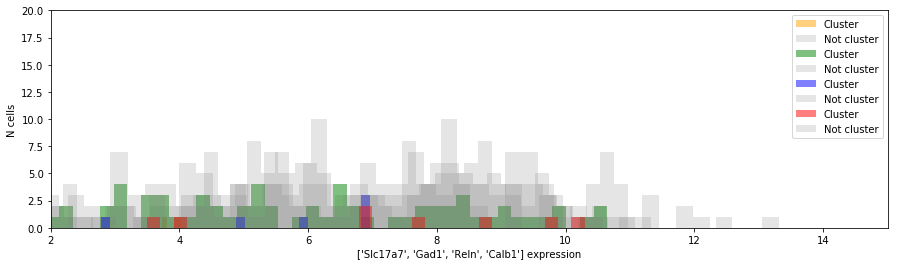

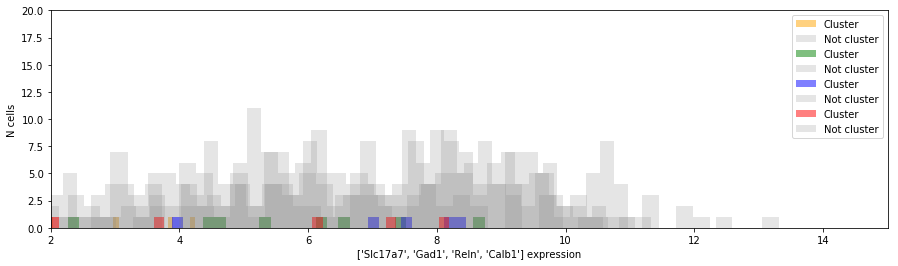

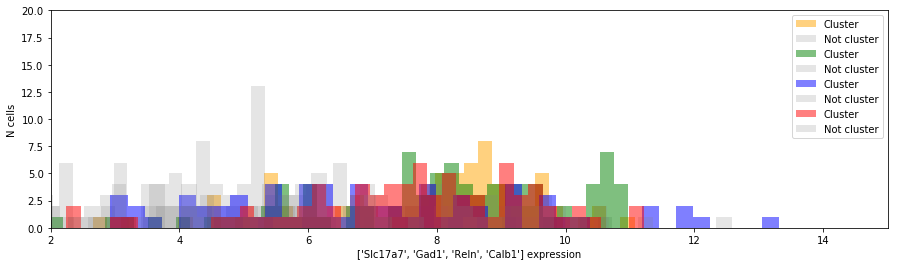

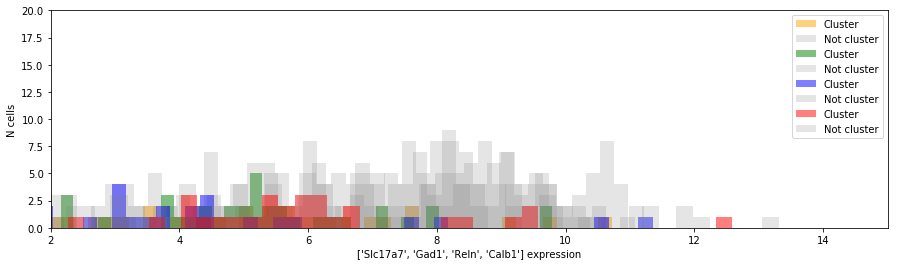

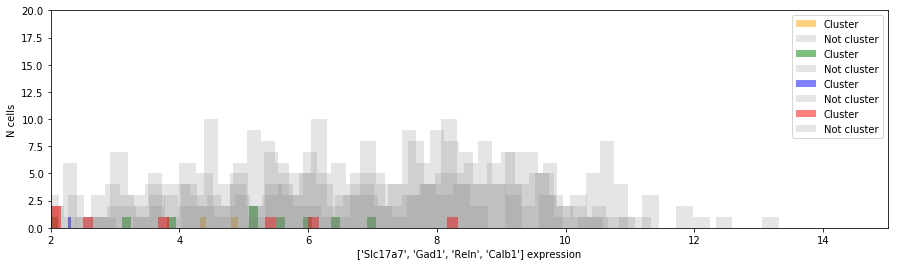

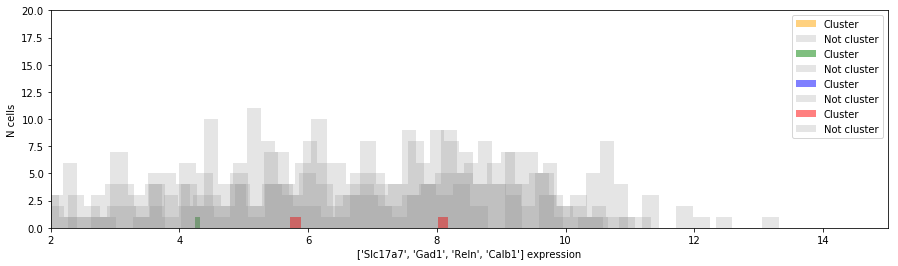

In [55]:
neuron_markers = ['Slc17a7','Gad1','Reln','Calb1']
colors = ['orange', 'green','b','r']
from scipy.stats import ttest_ind

for i in range(7):
    cluster_i = tsne_main[tsne_main['cluster'] == i]
    all_other_cells = tsne_main[tsne_main['cluster'] != i]
    
    plt.figure(figsize=(15,4))
    
    for number in range(4):
        cluster_i_marker = cluster_i[neuron_markers[number]] 
        plt.hist(cluster_i_marker, bins=50, color=colors[number], alpha=0.5, label='Cluster') # Plot distribution

        all_other_cells_marker = all_other_cells[neuron_markers[number]]
        plt.hist(all_other_cells_marker, bins=50, color='grey', alpha=0.2, label='Not cluster')

        plt.ylim(0,20)
        plt.xlim(2,15)
        plt.xlabel('%s expression'%neuron_markers) # label our axes
        plt.ylabel('N cells')
        plt.legend()

Нейроны конкретно заняли четвертый кластер, больше никакие типы клеток в нем так сильно не экспрессируются, что и хорошо, поскольку структура и функции, а соответственно и экспрессия генов у нейронов достаточно уникальна

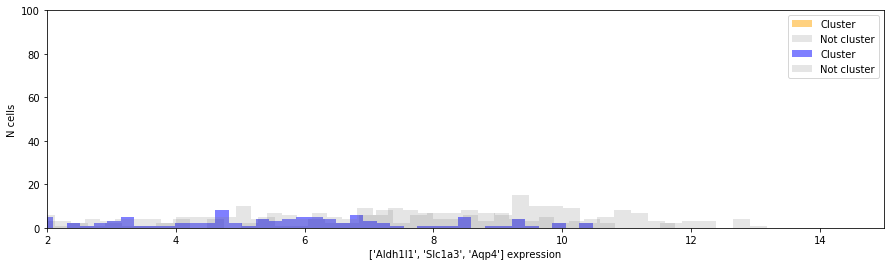

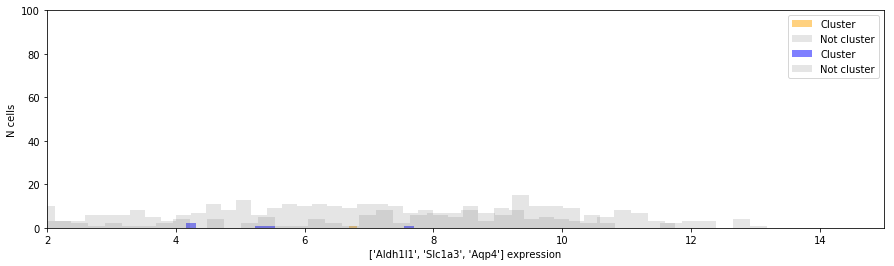

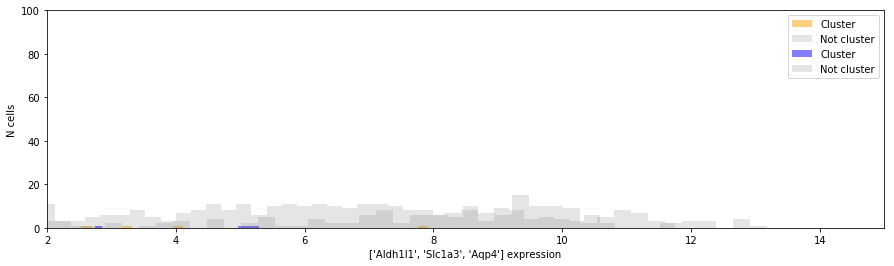

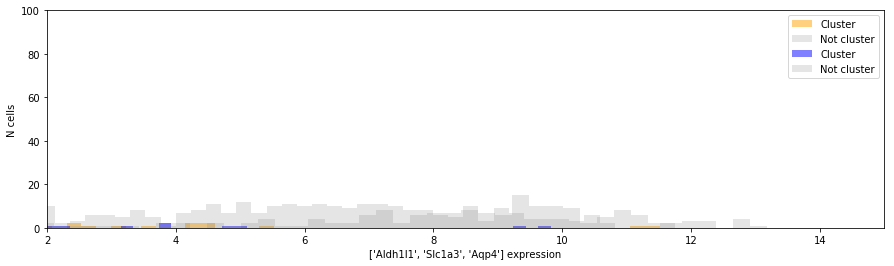

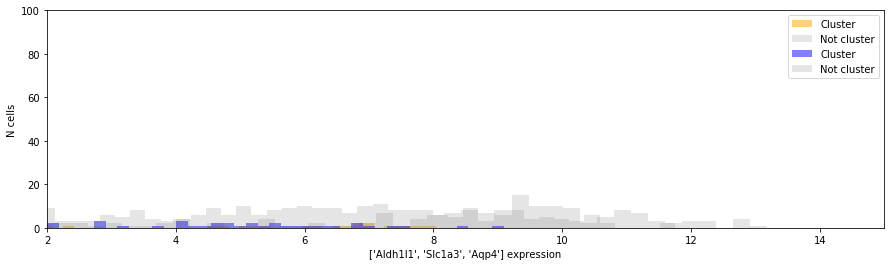

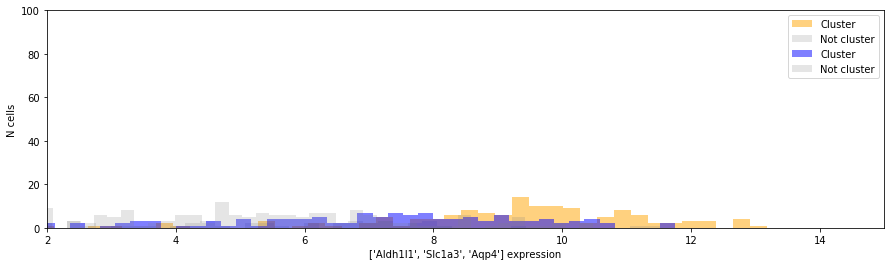

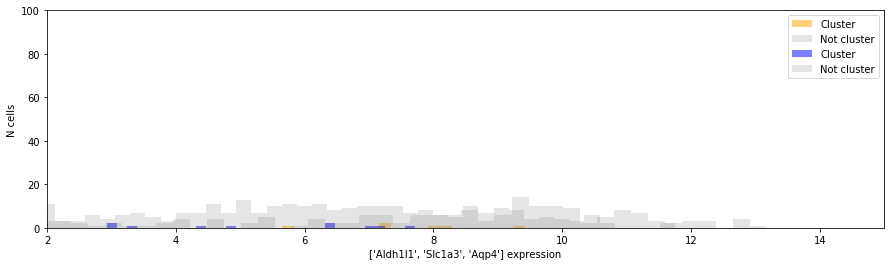

In [57]:
brainpericyte_markers = ['Des','Pdgfrb']
colors = ['orange','blue']
from scipy.stats import ttest_ind

for i in range(7):
    cluster_i = tsne_main[tsne_main['cluster'] == i]
    all_other_cells = tsne_main[tsne_main['cluster'] != i]
    
    plt.figure(figsize=(15,4))
    
    for number in range(2):
        cluster_i_marker = cluster_i[brainpericyte_markers[number]] 
        plt.hist(cluster_i_marker, bins=50, color=colors[number], alpha=0.5, label='Cluster') # Plot distribution

        all_other_cells_marker = all_other_cells[brainpericyte_markers[number]]
        plt.hist(all_other_cells_marker, bins=50, color='grey', alpha=0.2, label='Not cluster')

        plt.ylim(0,100)
        plt.xlim(2,15)
        plt.xlabel('%s expression'%astrocyte_marker) # label our axes
        plt.ylabel('N cells')
        plt.legend()

Перициты делят шестой кластер с клетками эндотелия, что не очень хорошо для определения природы самого кластера, но вполне объяснимо их крепкой связью - перициты обвиваются вокруг клеток эндотелия в капиллярах мозга

#### Вывод 
При анализе базы данных single cell RNA sequencing экспрессии генов мозга мыши получилось провести кластеризацию, в результате которой клетки были разбиты по их типу, что было проверено известными генами-маркерами